In [1]:
import numpy as np
import random as rn
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Normalization

# Fix seed for NumPy
np.random.seed(42)

# Fix seed for TensorFlow
tf.random.set_seed(42)

rn.seed(42)

tf.keras.utils.set_random_seed(42)

# Data generation and plot

In [2]:
def make_sine_ts(n_points, start_time=0, dimension=1, n_periods=4, ampl=10):
    sigma = ampl / 10
    time = np.arange(1, n_points + 1)
    series_sine = ampl * np.sin(np.tile(time * (2 * np.pi * n_periods) / n_points + start_time, (dimension, 1)).T) + sigma * np.random.randn(n_points, dimension)
    table = np.column_stack((time, series_sine))
    columns = ['Time'] + [f'Sine_{i}' for i in range(1, dimension + 1)]
    ts = pd.DataFrame(table, columns=columns)
    return ts

In [3]:
# generate synthetic time series
time = 500000
time_series_data = pd.DataFrame()
for i in range(28):
  ts = make_sine_ts(time, dimension=1, start_time=i * 10)
  time_series_data[f'Sine_{i+1}'] = ts.iloc[:, 1]
time_series_data

,Sine_1,Sine_2,Sine_3,Sine_4,Sine_5,Sine_6,Sine_7,Sine_8,Sine_9,Sine_10,...,Sine_19,Sine_20,Sine_21,Sine_22,Sine_23,Sine_24,Sine_25,Sine_26,Sine_27,Sine_28
0,0.497217,-6.503658,9.298829,-10.018320,8.515519,-3.087901,-4.155745,6.761862,-10.122948,8.129912,...,-6.787299,10.515523,-10.214769,6.224937,-0.134012,-6.372275,8.521845,-8.934159,6.005677,-1.905193
1,-0.137259,-6.261307,9.008358,-9.833064,6.953748,-1.567958,-4.818426,8.256200,-9.895204,9.407118,...,-6.252890,12.183682,-8.528483,5.866819,0.773012,-5.965893,9.047096,-11.491004,7.182516,-0.079388
2,0.649197,-4.758246,10.286693,-10.470742,7.579386,-2.304788,-3.387350,8.695239,-8.756535,7.312252,...,-8.106997,8.541812,-8.747523,4.362181,0.890155,-7.038727,9.793125,-10.618115,7.192885,-3.053790
3,1.525040,-5.023999,9.330359,-9.593537,5.970097,-3.081937,-2.547643,7.994574,-10.223428,9.714817,...,-8.088379,9.707112,-9.644432,4.559934,1.583819,-6.081536,10.010120,-9.884599,6.513398,-0.453277
4,-0.231640,-5.019861,9.995089,-12.345050,7.139608,-2.803368,-2.606996,7.881453,-10.264317,10.024044,...,-8.275953,9.007172,-11.797206,4.055618,1.258454,-5.195012,9.155152,-8.276825,4.816136,-2.346869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1.331610,-5.005519,11.045806,-9.072662,6.202448,-1.579102,-3.000656,7.146260,-8.603152,9.276178,...,-7.040916,10.604008,-8.147221,3.497439,2.050472,-4.679167,9.401032,-10.171174,6.709303,-1.560944
499996,-0.111264,-5.337173,8.345270,-9.980975,9.403580,-2.855766,-2.594933,8.081965,-11.012017,8.579396,...,-8.076067,9.392880,-8.679248,4.729691,1.935377,-6.885263,8.956104,-9.482445,6.596734,0.355482
499997,-0.244700,-5.552347,8.396881,-9.643462,6.636783,-2.613017,-2.584798,7.640324,-9.260246,9.577715,...,-7.690593,11.444883,-7.913844,5.496157,1.996778,-6.425471,9.931313,-8.826545,7.147098,-0.736237
499998,-0.797962,-3.970647,8.733367,-10.006217,6.389225,-2.123757,-4.265820,7.397909,-10.272636,7.342878,...,-7.761913,10.622368,-9.025079,6.211347,1.162714,-5.282455,10.086486,-10.105187,5.222044,-2.804623


# Forecast with score based model

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.metrics import mean_squared_error
from scipy.linalg import hankel
from sklearn.covariance import LedoitWolf

In [5]:
time_series_data.shape

(500000, 28)

In [6]:
window_size = 6

In [7]:
def create_hankel_matrix(time_series, window_size):
    hankel_matrix = hankel(time_series[:-window_size+1], time_series[-window_size:])
    return hankel_matrix

In [8]:
def calculate_distance_matrix(matrices):
    # Check if the matrices have the same number of vectors
    # matrices shape (num_series, num_times, window_sz)
    distances_matrix = np.zeros((matrices.shape[1], matrices.shape[0], matrices.shape[0]))

    # Iterate through the vectors in the matrices
    for i in range(distances_matrix.shape[0]):
        mu = np.mean(matrices[:,i,:], axis=-1)
        T = matrices.shape[2]
        for t in range(T):
          x = (matrices[:,i,t] - mu).reshape(-1, 1)
          distances_matrix[i] += x @ x.T
        distances_matrix[i] *= 1/T
    return distances_matrix

In [9]:
def reshape_to_2d(matrix):
    return matrix.reshape(matrix.shape[0], -1)

def reshape_to_3d(matrix, num):
    return matrix.reshape(matrix.shape[0], num, -1)

In [10]:
def get_distance_matrix(time_series, window_size=6):
    matrices = np.stack([create_hankel_matrix(time_series.iloc[:, i], window_size) for i in range(time_series.shape[1])])
    print(matrices.shape)
    distances = calculate_distance_matrix(matrices)
    print(distances.shape)
    return distances

In [11]:
X = get_distance_matrix(time_series_data)

(28, 499995, 6)
(499995, 28, 28)


In [12]:
X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])
X.shape

(499995, 1, 28, 28)

In [13]:
N = int(0.8 * len(X))
X_train, X_test = X[:N], X[N:]
X_train.shape, X_test.shape

((399996, 1, 28, 28), (99999, 1, 28, 28))

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools

from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
import tqdm

In [15]:
#@title Defining a time-dependent score-based model (double click to expand or collapse)

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.embed(t))
    # Encoding path
    h1 = self.conv1(x)
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [16]:
#@title Set up the SDE

device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The standard deviation.
  """
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)

sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [17]:
#@title Define the loss function (double click to expand or collapse)

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [18]:
#@title Training (double click to expand or collapse)

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs =   50#@param {'type':'integer'}
## size of a mini-batch
batch_size =  32 #@param {'type':'integer'}
## learning rate
lr=1e-4 #@param {'type':'number'}

# dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(X_train).float())
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)
    loss = loss_fn(score_model, x, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt.pth')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-16-f43414c747de>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [19]:
#@title Define the Euler-Maruyama sampler (double click to expand or collapse)

## The number of sampling steps.
num_steps =  500#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model,
                           init_x,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size=64,
                           num_steps=num_steps,
                           device='cuda',
                           eps=1e-3):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = init_x * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
  # Do not include any noise in the last sampling step.
  return mean_x

In [42]:
#@title Define the Predictor-Corrector sampler (double click to expand or collapse)

signal_to_noise_ratio = 0.16 #@param {'type':'number'}

## The number of sampling steps.
num_steps =  500#@param {'type':'integer'}
def pc_sampler(score_model,
               init_x,
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64,
               num_steps=num_steps,
               snr=signal_to_noise_ratio,
               device='cuda',
               eps=1e-3):
  """Generate samples from score-based models with Predictor-Corrector method.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = init_x * marginal_prob_std(t)[:, None, None, None]
  time_steps = np.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # Corrector step (Langevin MCMC)
      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
      x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)

      # Predictor step (Euler-Maruyama)
      g = diffusion_coeff(batch_time_step)
      x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)

    # The last step does not include any noise
    return x_mean

In [43]:
#@title Define the ODE sampler (double click to expand or collapse)

from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 #@param {'type': 'number'}
def ode_sampler(score_model,
                init_x,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                device='cuda',
                z=None,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = init_x * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z

  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    with torch.no_grad():
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x


<ipython-input-16-f43414c747de>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
<ipython-input-16-f43414c747de>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


Number of function evaluations: 290


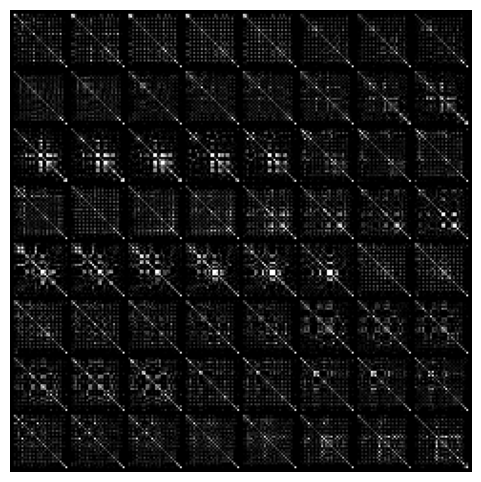

In [62]:
#@title Sampling (double click to expand or collapse)

from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = ode_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

init_x = torch.tensor(X_test[:sample_batch_size].copy(), device=device).float()
# init_x = torch.randn(sample_batch_size, 1, 28, 28, device=device)

## Generate samples using the specified sampler.
samples = sampler(score_model,
                  init_x,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  device=device)
test_sampled = samples
## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

Просемплировали первые 64 матрицы из X_test.

test_sampled - сгенерированные семплы

init_x - первые 64 матрицы из X_test

In [63]:
test_sampled.shape

torch.Size([64, 1, 28, 28])

Далее, чтобы выводится только небольшой угол матрицы (5 x 5)

Так выглядит первая сгенерированная матрица

In [64]:
test_sampled[0, 0, :5, :5]

tensor([[ 1.2607,  0.2827, -0.0887, -0.4888,  0.4323],
        [ 0.2480,  0.3359,  0.0516, -0.0825,  0.0881],
        [-0.0693, -0.0301,  0.2724, -0.0427,  0.0851],
        [-0.4273, -0.0964, -0.0165,  0.5173, -0.3786],
        [ 0.4271,  0.1012,  0.0454, -0.4077,  0.8874]], device='cuda:0',
       dtype=torch.float64)

вторая матрица из X_test (к которой хотелось бы нормально приблизить первую сгенерированную матрицу)

In [65]:
init_x = torch.tensor(X_test[:sample_batch_size].copy(), device=device).float()

In [66]:
init_x[1, 0, :5, :5]

tensor([[ 2.0444,  1.7438,  0.2346, -0.2732, -0.1702],
        [ 1.7438,  1.7142,  0.1825, -0.4120, -0.1365],
        [ 0.2346,  0.1825,  0.1054, -0.0522,  0.0075],
        [-0.2732, -0.4120, -0.0522,  0.7558, -0.2105],
        [-0.1702, -0.1365,  0.0075, -0.2105,  0.5151]], device='cuda:0')

Проектируем сгенерированную матрицу

In [67]:
from statsmodels.stats.correlation_tools import corr_nearest, cov_nearest

In [72]:
m = test_sampled[0, 0].cpu().numpy()
m = np.minimum( m, m.transpose() )
# m = m * m.transpose()
cov_nearest(m)[:5, :5]

array([[ 1.2606788 ,  0.25203891, -0.08424888, -0.42537638,  0.3866388 ],
       [ 0.25203891,  0.33587423, -0.02789081, -0.06622439,  0.07062489],
       [-0.08424888, -0.02789081,  0.27243285, -0.02661243,  0.06419943],
       [-0.42537638, -0.06622439, -0.02661243,  0.51728341, -0.3421899 ],
       [ 0.3866388 ,  0.07062489,  0.06419943, -0.3421899 ,  0.88735916]])

Как видно выше, psd матрица совсем не похожа на вторую матрицу из X_test